---
**Numerical continuation**

Week 17 of EMAT30008

https://engmaths.github.io/emat30008/odes/numericalcontinuation/

(See scicomp/odefunctions.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scicomp.odefunctions import *
from scipy.optimize import root

----------
We start by prototyping code for natural parameter continuation

We first conduct a single step of natural parameter continuation in the following cell:

In [8]:
# Define a basic polynomial with a parameter c
def polynomial(x,c):
    return x**3 -x + c

# Write out first step by hand
deltac = 0.1
c0 = -1

# Freeze the polynomial with c=c0, 
# Use root finding with an initial guess to find the corresponding root
xpolynomial = lambda x: polynomial(x, c=c0)
x0guess = 1
x0 = root(xpolynomial, x0guess).x
print("x_0 =", x0)

# Update the parameter c, and use the last solution as our initial guess
c1 = c0 + deltac
xpolynomial = lambda x: polynomial(x, c=c1)
x1 = root(xpolynomial, x0).x
print("x_1 =",x1)

x_0 = [1.32471796]
x_1 = [1.30073658]


[-1.32471796]


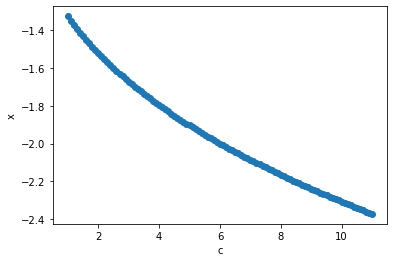

In [20]:
# Define basic polynomial
def polynomial(x,c):
    return x**3 -x + c

# Write out first step by hand
c0 = 1
deltac = 0.1
x0guess = -5
xpolynomial = lambda x: polynomial(x, c=c0)
x0 = fsolve(xpolynomial, x0guess)
print(x0)

# Define a basic step function
def natural_param_step(xi, ci):
    c_next = ci + deltac
    xpolynomial = lambda x: polynomial(x, c=c_next)
    x_next = fsolve(xpolynomial, xi)
    return x_next, c_next

# Do some steps
x_store = [x0]
c_store = [c0]

x = x0
c = c0
for i in range(100):
    x, c = natural_param_step(x, c)
    x_store += [x]
    c_store += [c]

# Plot
plt.scatter(c_store, x_store)
plt.xlabel("c")
plt.ylabel("x")
plt.show()

This shows a very basic natural parameter continuation for the polynomial $x^3 -x + c$. 
Note if we change `x0guess` above we get a different plot.

We now do the same but for pseudo-arclength continuation.

------------
Pseudo-arclength continuation


[[10.         -2.30890732]
 [ 9.999      -2.37364982]
 [12.80298865 -2.48171763]
 [15.60534182 -2.63222047]
 [18.40856239 -2.76657254]
 [21.2123767  -2.88853631]
 [24.01661995 -3.00063909]
 [26.82118586 -3.1046706 ]
 [29.62600222 -3.20195039]
 [32.43101792 -3.29348272]
 [35.23619557 -3.3800518 ]
 [38.04150709 -3.46228319]]


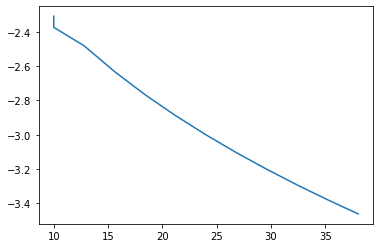

In [21]:
# Redefine polynomial in question, we keep x in array form
def polynomial(c: float, x: np.ndarray):
    return x[0]**3 - x[0] + c

# Setup
c0, x0guess = 10, np.array(([-10]))
fixed_poly = lambda x: polynomial(c=c0,x=x)
x0 = fsolve(fixed_poly, x0guess)

deltac = -0.001
c1 = c0 + deltac
x1guess = x0
x1 = fsolve(fixed_poly, x0)

v0 = np.concatenate(([c0],x0))
v1 = np.concatenate(([c1],x1))

# Initialise stores
v_store = np.stack((v0, v1))
v_last = v0
v_current = v1
num_steps = 10

# Define objective function
def objective(v: np.ndarray, v_next_guess: np.ndarray, secant: np.ndarray):
    original = polynomial(c=v[0], x=v[1:])
    pseudo_arclength_eq = np.dot((v - v_next_guess),secant)
    return np.array(([original, pseudo_arclength_eq]))

for i in range(num_steps):
    # Calculate secant and next guess
    secant = v_current - v_last
    v_next_guess = v_current + secant

    # Define current objective function and solve for v_next
    current_objective = lambda v: objective(v, v_next_guess, secant)
    v_next = fsolve(current_objective, v_next_guess)

    # Update
    v_store = np.vstack((v_store, v_next))
    v_last = v_current
    v_current = v_next

print(v_store)
plt.plot(v_store[:,0], v_store[:,1])

We now write functions for both to generalise the methods

In [ ]:
def natural_param_cont(objective, init_param, init_solution_guess, param_step, num_steps):
    
    


TODO: 
-solve $x^3 - x + c = 0$ on paper so we know what to look for

-look at paper notes in folder for review

-implement pseudo-arclength continuation, perhaps find nice way to plot search lines

-make and test framework that can take this and use it for the limit cycle shooting problem, or for equillibria finding. Look at dictionary vs array of parameters, choosing which param to vary etc.

-make functionality to do continuation backwards, and functionality to run continuation multiple times and add new points

-should reproduce some of the tools that XPPauto uses.

[[2 3 6]
 [2 3 4]]
